## b) [3 pts] PCA for feature selection: 
Use PCA on MNIST dataset to select features by retaining the following levels of variance (information): 50%, 75%, 90%, 95%. For each of this variance level, you need to: 
(i) 

1.   Use the retained features to train a simple feed-forward neural network with one hidden layer to classify the images
2.   Reconstruct the 28×28 images from the retained features (obtained using PCA with different variance levels) and train the CNN network defined in Q1 to classify these images

Plot the performances (in terms of accuracy) for parts (i) and (ii). Explain your observations from parts (i) and (ii) in terms of performance.

In [0]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# PyTorch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# torchvision for loading MNIST dataset
import torchvision
from torchvision import datasets, transforms
# For plotting
import matplotlib.pyplot as plt

In [0]:
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True, 
                            transform=transforms.Compose([
                                                          transforms.ToTensor()
                                                          ]))

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False, 
                           transform=transforms.Compose([
                                                         transforms.ToTensor()
                                                         ]))

classes = [i for i in range(10)]

print("Training examples: ", len(train_data))
print("Test examples: ", len(test_data))

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw




Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!
Training examples:  60000
Test examples:  10000


In [0]:
train_data_reshaped = train_data.data.reshape(60000,784)
test_data_reshaped = test_data.data.reshape(10000,784)

In [0]:
def eval_net(epochs, batch_size, features):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  temp_train = torch.utils.data.TensorDataset(train_data_final, train_data.targets)
  temp_test = torch.utils.data.TensorDataset(test_data_final, test_data.targets)
  train_loader = torch.utils.data.DataLoader(temp_train, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(temp_test, batch_size=batch_size, shuffle=False)
  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(features, 120) # connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 10)       # 120 hidden units in, 154 hidden units out

    def forward(self, x):
      x = self.fc1(x)
      x = F.log_softmax(self.fc2(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients

      outputs = net(inputs.float()) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

In [0]:
def eval_net_b(epochs, batch_size):

  ##### Prepare return values ##################################################
  losses = []
  train_acc = 0
  test_acc = 0

  ##### Create iterators for each dataset ######################################
  temp_train = torch.utils.data.TensorDataset(train_data_final_, train_data.targets)
  temp_test = torch.utils.data.TensorDataset(test_data_final_, test_data.targets)
  train_loader = torch.utils.data.DataLoader(temp_train, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(temp_test, batch_size=batch_size, shuffle=False)
  # train_loader = torch.utils.data.DataLoader(train_data_final_re, batch_size=batch_size, shuffle=True)
  # test_loader = torch.utils.data.DataLoader(train_data_final_re, batch_size=batch_size, shuffle=False)

  ##### Define the network #####################################################
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
      self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
      self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
      self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
      self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
      self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

    def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = x.view(-1, 16 * 5 * 5) # .view() is similar to .reshape(), so this flattens x into a vector
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.log_softmax(self.fc3(x), dim=1)
      return x
  
  ##### Initialize the network and optimizer ###################################
  print("Initializing the network ...")
  net = Net()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # lr = learning rate/step size

  ##### Training the network ###################################################
  print("Training the network ...")
  for e in range(epochs):  # loop over the dataset multiple times
    print("Epoch: ", e+1)
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      optimizer.zero_grad() # zero the parameter gradients
      
      outputs = net(inputs.float()) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # gradient descent update

      losses.append(loss.item())

  ##### Evaluating the network on training data ################################
  print("Evaluating on training data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      inputs, labels = data
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = correct / total

  ##### Evaluating the network on test data ####################################
  print("Evaluating on test data ...")
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      inputs, labels = data
      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = correct / total

  return losses, train_acc, test_acc

In [0]:
variance_list=[0.95, 0.90, 0.75, 0.50]

154
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8721333333333333
Test accuracy:  0.8759


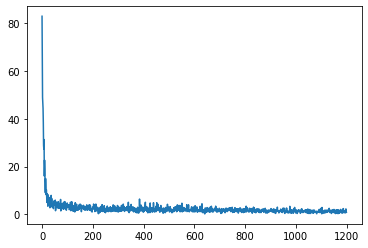

87
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.8619
Test accuracy:  0.8663


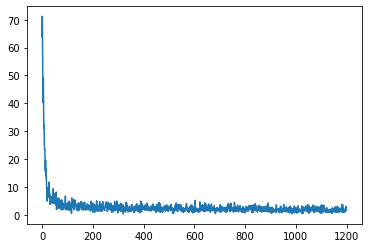

34
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.82505
Test accuracy:  0.8299


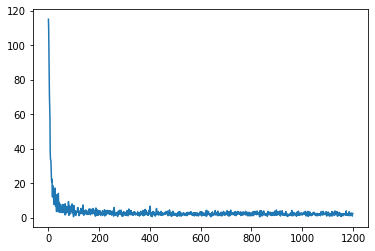

11
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.7010666666666666
Test accuracy:  0.7077


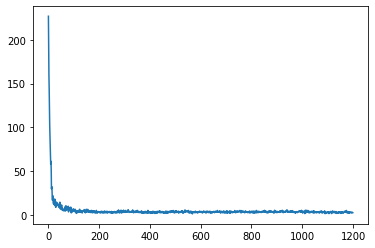

[0.8759, 0.8663, 0.8299, 0.7077]


In [0]:
test_accuracies_FNN=[]
for variance in variance_list:
  pca = PCA(n_components=variance)
  pca.fit(train_data_reshaped)
  print(pca.n_components_)
  input_train_data = pca.transform(train_data_reshaped)
  input_test_data = pca.transform(test_data_reshaped)
  train_data_final = torch.from_numpy(input_train_data)
  test_data_final = torch.from_numpy(input_test_data)
  losses, train_acc, test_acc = eval_net(epochs=2, batch_size=100, features = pca.n_components_ )
  print("Training accuracy: ", train_acc)
  print("Test accuracy: ", test_acc)
  test_accuracies_FNN.append(test_acc)
  plt.plot(losses)
  plt.show()
print(test_accuracies_FNN)

154
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.97995
Test accuracy:  0.9778


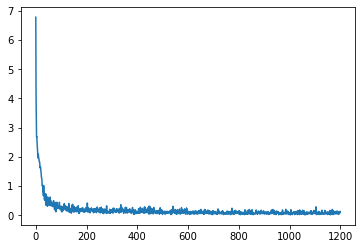

87
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.97675
Test accuracy:  0.9765


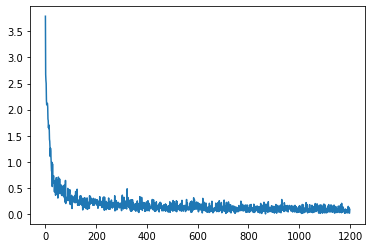

34
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9742666666666666
Test accuracy:  0.9734


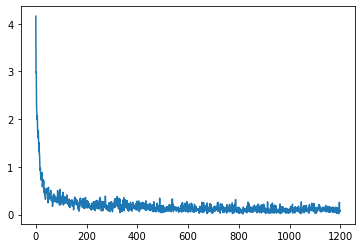

11
Initializing the network ...
Training the network ...
Epoch:  1
Epoch:  2
Evaluating on training data ...
Evaluating on test data ...
Training accuracy:  0.9196333333333333
Test accuracy:  0.92


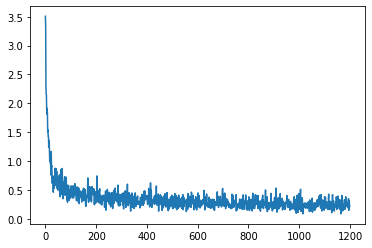

[0.9778, 0.9765, 0.9734, 0.92]


In [0]:
variance_list=[0.95, 0.90, 0.75, 0.50]
test_accuracies_CNN = []
for variance in variance_list:
  pca = PCA(n_components=variance)
  pca.fit(train_data_reshaped)
  print(pca.n_components_)
  input_train_data = pca.transform(train_data_reshaped)
  input_test_data = pca.transform(test_data_reshaped)
  restored_train_data = pca.inverse_transform(input_train_data)
  restored_test_data = pca.inverse_transform(input_test_data)
  train_data_temp_ = torch.from_numpy(restored_train_data)
  test_data_temp_ = torch.from_numpy(restored_test_data)
  train_data_final_ = train_data_temp_.reshape(-1,1,28,28)
  test_data_final_ = test_data_temp_.reshape(-1,1,28,28)
  losses, train_acc, test_acc = eval_net_b(epochs=2, batch_size=100)
  print("Training accuracy: ", train_acc)
  print("Test accuracy: ", test_acc)
  test_accuracies_CNN.append(test_acc)
  plt.plot(losses)
  plt.show()
print(test_accuracies_CNN)

In [0]:
import copy
print(test_accuracies_CNN)
print(test_accuracies_FNN)
acc_CNN = copy.deepcopy(test_accuracies_CNN)
acc_FNN = copy.deepcopy(test_accuracies_FNN)
print(acc_CNN)
print(acc_FNN)


[0.9778, 0.9765, 0.9734, 0.92]
[0.8759, 0.8663, 0.8299, 0.7077]
[0.9778, 0.9765, 0.9734, 0.92]
[0.8759, 0.8663, 0.8299, 0.7077]


In [0]:
acc_CNN = [ '%.2f' % elem for elem in acc_CNN ]
acc_FNN = [ '%.2f' % elem for elem in acc_FNN ]
print(acc_CNN)
print(acc_FNN)

['0.98', '0.98', '0.97', '0.92']
['0.88', '0.87', '0.83', '0.71']


In [0]:
acc_CNN = [float(i) for i in acc_CNN]
acc_FNN = [float(i) for i in acc_FNN]
print(acc_CNN)
print(acc_FNN)

[0.98, 0.98, 0.97, 0.92]
[0.88, 0.87, 0.83, 0.71]


In [0]:
acc_CNN = sorted(acc_CNN)
acc_FNN = sorted(acc_FNN)
print(acc_CNN)
print(acc_FNN)

[0.92, 0.97, 0.98, 0.98]
[0.71, 0.83, 0.87, 0.88]


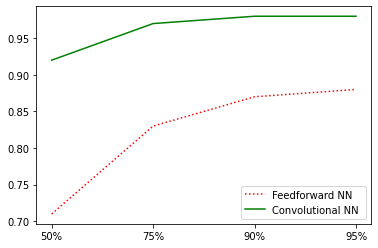

In [0]:
var_lvls = ['50%','75%','90%','95%']
plt.plot(acc_FNN, linestyle=':', color='r', label='Feedforward NN')
plt.plot(acc_CNN, linestyle='-', color='g', label='Convolutional NN ')
plt.xticks([0,1,2,3], var_lvls)
plt.legend(loc='best')

## Observations:


1.   With the different retained variance levels, CNN does an excellent job in classifying reconstructed images. In contrast, Feedforward NN(FNN) does satisfactory job even with original images. 
2.   The accuracy plot shows as that the plot for FNN becomes very steep once we have extremely low amount of features. 

